# Import Library

In [1]:
import numpy as np
import pandas as pd
import os
from os import path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix

import math

import pickle

In [2]:
from tqdm import tqdm

In [3]:
from DistanceMetricsVec import CVM_Dist_PVal as CVM_p
from DistanceMetricsVec import Anderson_Darling_Dist_PVal as AD_p
from DistanceMetricsVec import Kolmogorov_Smirnov_Dist_PVal as KS_p
from DistanceMetricsVec import Wasserstein_Dist_PVal as WS_p
from DistanceMetricsVec import DTS_Dist_PVal as DTS_p
from DistanceMetricsVec import ES_Dist

In [15]:
from utils.CriticalValues import KS_crit, AD_crit

# Prepare Set

In [4]:
dfs = [pd.read_csv(path.join('new_data/town1',x)) for x in os.listdir("new_data/town1") if path.isfile(path.join("new_data/town1",x))]
completedf = pd.concat(dfs)

In [5]:
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile') #oridinal\ quantile

completedf["y_disc"] = est.fit_transform(np.array(completedf.speed).reshape(-1, 1))

In [6]:
X = completedf[["latitude", "longitude", "altitude"]]
y = completedf["y_disc"]
X_train_init, X_test, y_train_init, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_cal, X_eval, y_cal, y_eval = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

## OOD Injection

In [7]:
grad = completedf.altitude.diff()
incline = grad[grad > 0]
print(incline.mean(), incline.max(), incline.min(), incline.var())

0.002985964895215438 8.015169912716374 2.3283059985210186e-10 0.0007099169658452785


In [8]:
X_train = X_train_init[X_train_init.altitude.diff() < 0.08]
y_train = y_train_init[X_train_init.altitude.diff() < 0.08]
print(X_train.shape, y_train.shape)

(101180, 3) (101180,)


## Build Model

In [9]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('KNC', KNeighborsClassifier(n_neighbors = 3))])

In [10]:
pipe.fit(X_train, np.array(y_train).ravel())

Pipeline(steps=[('scaler', StandardScaler()),
                ('KNC', KNeighborsClassifier(n_neighbors=3))])

In [11]:
y_pred = pipe.predict(X_cal).reshape(-1, 1)
y_real = y_cal.values.reshape(-1, 1)

In [12]:
print('Classification Report')
print(classification_report(y_cal, y_pred))

Classification Report
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     15965
         1.0       0.96      0.95      0.95     16035
         2.0       0.97      0.97      0.97     16001

    accuracy                           0.96     48001
   macro avg       0.96      0.96      0.96     48001
weighted avg       0.96      0.96      0.96     48001



In [13]:
#Create mask for incorrect data
mask = np.zeros(len(y_pred))
for idx, yp in enumerate(y_pred):
    mask[idx] = yp == y_real[idx]
    
print(mask)

[1. 1. 1. ... 1. 1. 1.]


In [14]:
print(len(mask) - mask.sum() ) # Number of incorrect examples

1766.0


## Bootstrap power analysis

In [25]:
train_samplespace = X_train.values
test_correct = X_cal[mask == 1].values
test_incorrect = X_cal[mask == 0].values

In [27]:
test_incorrect

array([[-2.74532719e-04, -6.65143280e-04,  2.51832485e-01],
       [ 1.26957174e-03,  7.36655474e-04,  8.05942345e+00],
       [ 1.56267026e-03,  1.35431995e-03,  1.19927764e+00],
       ...,
       [ 1.02836101e-04,  6.83422384e-04,  2.66005039e-01],
       [ 1.22890274e-03,  1.34143202e-03,  8.07414436e+00],
       [ 5.95166430e-04,  7.15566325e-04,  7.76212740e+00]])

In [28]:
def get_statistical_distance_bootstrap(train_set, test_set):
    #return statistical distance measures
    if (train_set.shape[1] != test_set.shape[1]):
        print(f"input features are not compatible. input one size {train_set.shape[1]} does not match input two size {test_set.shape[1]}")
        return None
    else:
        input_features = train_set.shape[1]
        
    input_features = train_set.shape[1]
    

    ss_Anderson_Darling_distances = np.zeros(input_features)
    ss_Kolmogorov_Smirnov_distances = np.zeros(input_features)

    for i in range(input_features):

        pVal_ad, ad_res = AD_p(train_set[:, i], test_set[:, i])
        ss_Anderson_Darling_distances[i] = ad_res if (pVal_ad < 0.05) else np.nan
        
        
        pVal_ks, ks_res = KS_p(train_set[:, i], test_set[:, i])
        ss_Kolmogorov_Smirnov_distances[i] = ks_res if (pVal_ks < 0.05) else np.nan
        


    Anderson_Darling_distance = (np.nanmean(ss_Anderson_Darling_distances, dtype=np.float64),
                                 np.nanstd(ss_Anderson_Darling_distances, dtype=np.float64))
    Kolmogorov_Smirnov_distance = (np.nanmean(ss_Kolmogorov_Smirnov_distances, dtype=np.float64),
                                   np.nanstd(ss_Kolmogorov_Smirnov_distances, dtype=np.float64))

    
    return {
            'Anderson_Darling_dist': Anderson_Darling_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
           }

In [ ]:
value_range = range(50, 201, 10)
trails = 100
alpha = 0.1

crit_vals = np.zeros((2, len(value_range)))
false_positive = np.zeros((2, len(value_range)))
false_negative = np.zeros((2, len(value_range)))


for idx, smp_n in (enumerate(value_range)):
    crit_vals[0, idx] = AD_crit(alpha, smp_n, smp_n, trails)
    crit_vals[1, idx] = KS_crit(alpha/trails, smp_n, smp_n)
    
    for sim_number in range(trails):
        #print("sim: ", sim_number)
        
        idx_train = np.random.choice(train_samplespace.shape[0], smp_n, replace=False)
        idx_correct = np.random.choice(test_correct.shape[0], smp_n, replace=False)
        idx_incorrect = np.random.choice(test_incorrect.shape[0], smp_n, replace=False)
        print()
        dist_correct = get_statistical_distance_bootstrap(train_samplespace[idx_train], test_correct[idx_correct])
        dist_incorrect = get_statistical_distance_bootstrap(train_samplespace[idx_train], test_incorrect[idx_incorrect])
    
        for test, col in enumerate(["Anderson_Darling_dist", "Kolmogorov_Smirnov_dist"]):
            
            false_positive[test, idx] += 1 if dist_correct[col][0] > crit_vals[test, idx] else 0
            false_negative[test, idx] += 1 if dist_incorrect[col][0] < crit_vals[test, idx] else 0
    

In [51]:
power = (2*trails - false_positive - false_negative)/(2*trails)
fnr = false_negative/100

In [52]:
def nan_helper(y):

    return np.isnan(y), lambda z: z.nonzero()[0]

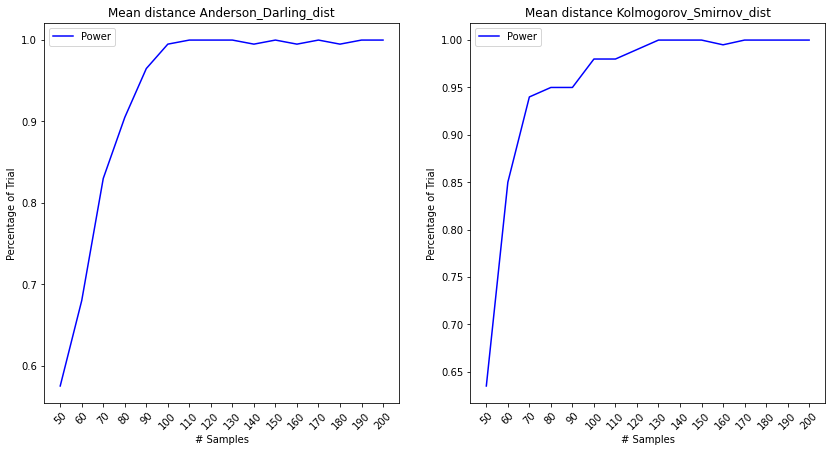

In [71]:
fig=plt.figure(figsize=[14,7])
columns = 2
rows = 1
column_names = ["Anderson_Darling_dist", "Kolmogorov_Smirnov_dist"]
for i in range(2):
    plt.subplot(rows, columns, i+1)
    y1 = power[i,:]
    #print(y1, y2)
    nans, x= nan_helper(y1)
    if (nans.sum()):
        y1[nans]= np.interp(x(nans), x(~nans), y1[~nans])

    plt.plot(y1, 'b')
    #plt.plot(y2, 'r')
    plt.xticks(range(16), range(50, 201, 10), rotation = 45)
    title_str = "Mean distance " + column_names[i]
    plt.title(title_str)
    plt.legend(["Power", "False negative rate"], loc = 2)
    plt.ylabel("Percentage of Trial")
    plt.xlabel("# Samples")
plt.show()

## Create Calibration Set

In [15]:
def design_windowed_series(data_input, required_samples, instance_num):
    correct, incorrect = data_input
    
    _out = np.zeros((instance_num, required_samples, correct.shape[1]))
    _acc = np.zeros(instance_num)
    rng = np.random.default_rng()
    for idx, x in enumerate(np.linspace(0, required_samples, instance_num)):
        samples = math.ceil(x)
        _acc[idx] = 1 - (samples / required_samples) #decrease accuracy over time
        incorrect_id = np.random.choice(incorrect.shape[0], samples)
        correct_id = np.random.choice(correct.shape[0], required_samples - samples)
        
        _out[idx] = (np.concatenate((incorrect[incorrect_id, :], correct[correct_id, :]), axis = 0))
        rng.shuffle(_out[idx], axis = 0)
        
    return _out, _acc

In [16]:
cal_correct = X_cal.values[mask == 1]
cal_incorrect = X_cal.values[mask ==0]

print(cal_correct.shape, cal_incorrect.shape)

(46235, 3) (1766, 3)


In [17]:
required_samples = 150
designed_series, accuracy = design_windowed_series((cal_correct, cal_incorrect), required_samples, 1000)


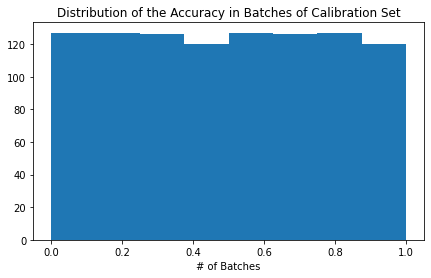

In [18]:
plt.figure(figsize=[7,4])
plt.hist(accuracy, bins=8)
plt.title("Distribution of the Accuracy in Batches of Calibration Set")
plt.xlabel("Accuracy")
plt.xlabel("# of Batches")
plt.show()

# Fit Estimators

In [19]:
def get_statistical_distance_gpu(train_set, test_set):
    #return statistical distance measures
    if (train_set.shape[1] != test_set.shape[1]):
        print(f"input features are not compatible. input one size {train_set.shape[1]} does not match input two size {test_set.shape[1]}")
        return None
    else:
        input_features = train_set.shape[1]
        
    input_features = train_set.shape[1]
    

    ss_CVM_distances = np.zeros(input_features)
    ss_Anderson_Darling_distances = np.zeros(input_features)
    ss_Kolmogorov_Smirnov_distances = np.zeros(input_features)
    ss_Wasserstein_distances = np.zeros(input_features)
    ss_DTS_distances = np.zeros(input_features)
    es_distances = np.zeros(input_features)
    for i in range(input_features):
        
        pVal_cvm, cvm_res = CVM_p(train_set[:, i], test_set[:, i])
        ss_CVM_distances[i] = cvm_res if (pVal_cvm < 0.05) else np.nan

        
        pVal_ad, ad_res = AD_p(train_set[:, i], test_set[:, i])
        ss_Anderson_Darling_distances[i] = ad_res if (pVal_ad < 0.05) else np.nan
        
        
        pVal_ks, ks_res = KS_p(train_set[:, i], test_set[:, i])
        ss_Kolmogorov_Smirnov_distances[i] = ks_res if (pVal_ks < 0.05) else np.nan
        
        
        pVal_ws, ws_res = WS_p(train_set[:, i], test_set[:, i])
        ss_Wasserstein_distances[i] = ws_res if (pVal_ws < 0.05) else np.nan

        
        pVal_dts, dts_res = DTS_p(train_set[:, i], test_set[:, i])
        ss_DTS_distances[i] = dts_res if (pVal_dts < 0.05) else np.nan
        
        es_distances[i], _ = ES_Dist(train_set[:, i], test_set[:, i])
    
    CVM_distance = (np.nanmean(ss_CVM_distances, dtype=np.float64), 
                    np.nanstd(ss_CVM_distances, dtype=np.float64))
    Anderson_Darling_distance = (np.nanmean(ss_Anderson_Darling_distances, dtype=np.float64),
                                 np.nanstd(ss_Anderson_Darling_distances, dtype=np.float64))
    Kolmogorov_Smirnov_distance = (np.nanmean(ss_Kolmogorov_Smirnov_distances, dtype=np.float64),
                                   np.nanstd(ss_Kolmogorov_Smirnov_distances, dtype=np.float64))
    Wasserstein_distance = (np.nanmean(ss_Wasserstein_distances, dtype=np.float64),
                            np.nanstd(ss_Wasserstein_distances, dtype=np.float64))
    
    dts_distance = (np.nanmean(ss_DTS_distances, dtype=np.float64),
                            np.nanstd(ss_DTS_distances, dtype=np.float64))
    
    es_distance = (np.nanmean(es_distances, dtype=np.float64),
                            np.nanstd(es_distances, dtype=np.float64))
    

    
    return {
            'CVM_dist': CVM_distance,
            'Anderson_Darling_dist': Anderson_Darling_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Wasserstein_dist': Wasserstein_distance,
            'DTS_dist' : dts_distance,
            "ES_dist"  : es_distance
           }

In [20]:
def distance_list(input_series, train_ref, acc_list):
    N = len(acc_list)
    
    cvm = np.zeros(N)
    ad = np.zeros(N)
    ks = np.zeros(N)
    ws = np.zeros(N)
    dts = np.zeros(N)
    es = np.zeros(N)
    
    for i in tqdm(range(N)):
        dist = get_statistical_distance_gpu(train_ref, input_series[i, :, :])
        
        cvm[i] = dist['CVM_dist'][0]
        ad[i] = dist['Anderson_Darling_dist'][0]
        ks[i] = dist['Kolmogorov_Smirnov_dist'][0]
        ws[i] = dist['Wasserstein_dist'][0]
        dts[i] = dist['DTS_dist'][0]
        es[i] = dist['ES_dist'][0]
        
    return (cvm, ad, ks, ws, dts, es)

In [21]:
#prepare a training sample
idx_train = np.random.choice(X_train.shape[0], required_samples * 2, replace=False)
train_samples = X_train.values[idx_train]

train_samples.shape

(300, 3)

In [22]:

cvm, ad, ks, ws, dts, es = distance_list(designed_series, train_samples, accuracy)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [24:00<00:00,  1.44s/it]


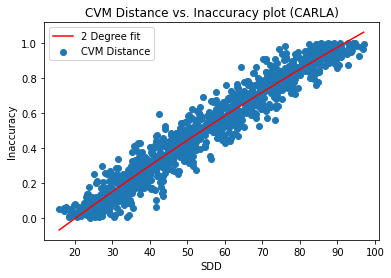

In [37]:
z = np.polyfit(cvm, 1 - accuracy, 2)
x_fit = np.linspace(cvm.min(), cvm.max(), cvm.shape[0])
fit = np.poly1d(z)(x_fit)

plt.figure()
plt.grid()
plt.scatter(cvm, 1 - accuracy,  label='CVM Distance')
plt.plot(x_fit, fit, "r")
plt.title('CVM Distance vs. Inaccuracy plot (CARLA)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.grid()
plt.legend(["2 Degree fit", "CVM Distance"])


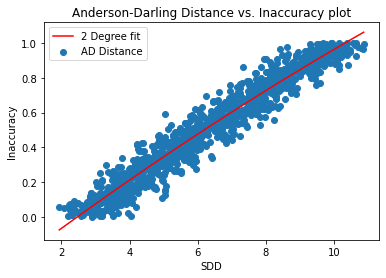

In [32]:
z = np.polyfit(ad, 1 - accuracy, 2)
x_fit = np.linspace(ad.min(), ad.max(), ad.shape[0])
fit = np.poly1d(z)(x_fit)


plt.figure()
plt.scatter(ad, 1 - accuracy, label='Anderson-Darling Distance')
plt.plot(x_fit, fit, "r")
plt.title('Anderson-Darling Distance vs. Inaccuracy plot (CARLA)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')

plt.legend(["2 Degree fit", "AD Distance"])


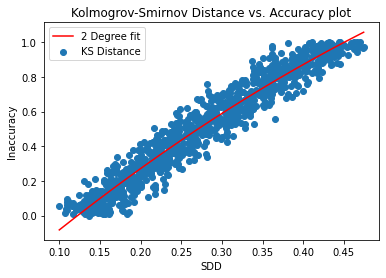

In [33]:
z = np.polyfit(ks, 1 - accuracy, 2)
x_fit = np.linspace(ks.min(), ks.max(), ks.shape[0])
fit = np.poly1d(z)(x_fit)


plt.figure()
plt.scatter(ks, 1 - accuracy, label='Anderson-Darling Distance')
plt.plot(x_fit, fit, "r")
plt.title('Kolmogrov-Smirnov Distance vs. Inaccuracy plot (CARLA)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')

plt.legend(["2 Degree fit", "KS Distance"])

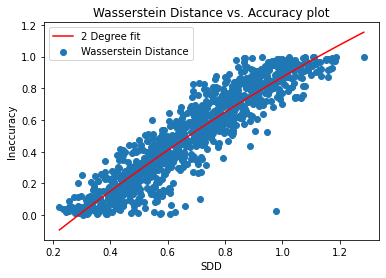

In [34]:
z = np.polyfit(ws, 1 - accuracy, 2)
x_fit = np.linspace(ws.min(), ws.max(), ws.shape[0])
fit = np.poly1d(z)(x_fit)


plt.figure()
plt.scatter(ws, 1 - accuracy, label='Anderson-Darling Distance')
plt.plot(x_fit, fit, "r")
plt.title('Wasserstein Distance vs. Inaccuracy plot (CARLA)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')

plt.legend(["2 Degree fit", "Wasserstein Distance"])

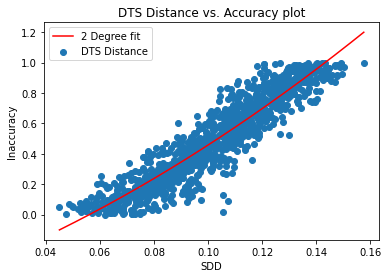

In [35]:
z = np.polyfit(dts, 1 - accuracy, 2)
x_fit = np.linspace(dts.min(), dts.max(), dts.shape[0])
fit = np.poly1d(z)(x_fit)


plt.figure()
plt.scatter(dts, 1 - accuracy, label='Anderson-Darling Distance')
plt.plot(x_fit, fit, "r")
plt.title('DTS Distance vs. Inccuracy plot (CARLA)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')

plt.legend(["2 Degree fit", "DTS Distance"])

Parameters: [ 0.4533852   6.80551553 -1.24977493]
RMSE: 0.2910703069588635
R-squared: 0.8909863675699705


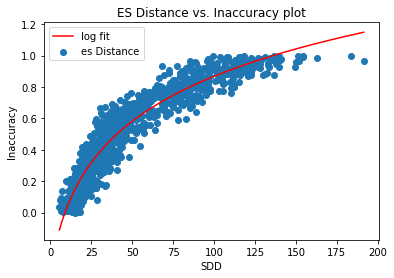

In [36]:
from scipy.optimize import curve_fit

def ln_fun(x, a, b, c): 
    return a*np.log(x + b)+c


x_fit = np.linspace(es.min(), es.max(), es.shape[0])



# these are the same as the scipy defaults
param_init = np.array([1.0, 1.0, 1.0])

# curve fit the test data
param_fit, pcov = curve_fit(ln_fun, es, (1 - accuracy), param_init)

fit_log = ln_fun(x_fit, *param_fit) 

absError = fit_log - (1 - accuracy)

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(1 - accuracy))

print('Parameters:', param_fit)
print('RMSE:', RMSE)
print('R-squared:', Rsquared)


plt.figure()
plt.scatter(es, 1 - accuracy,  label='ES Distance')
plt.plot(x_fit, fit_log, "r")
plt.title('ES Distance vs. Inaccuracy plot (CARLA)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')

plt.legend(["log fit", "es Distance"])
